In [39]:
import os
import numpy as np 
import pandas as pd 
from subprocess import check_output

In [40]:
sub_path = "Submissions"
all_files = os.listdir(sub_path)

# Read and concatenate submissions
outs = [pd.read_csv(os.path.join(sub_path, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "is_iceberg_" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()

,id,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4,is_iceberg_5,is_iceberg_6,is_iceberg_7
0,5941774d,0.000221,0.005679,2.138313e-02,0.010011,0.003657,0.016455,0.220130,0.023473
1,4023181e,0.038992,0.081089,6.183937e-01,0.404991,0.020802,0.986631,0.014379,0.375685
2,b20200e4,0.000028,0.143951,9.098931e-07,0.007189,0.001704,0.001559,0.000041,0.006849
3,e7f018bb,0.990785,0.990662,9.738217e-01,0.997395,0.999148,0.999509,0.992729,0.998656
4,4371c8c3,0.004350,0.333731,4.257437e-01,0.067517,0.001759,0.997644,0.074289,0.035506


In [41]:
model_amount = len(concat_sub.columns)
print(model_amount)

9


In [42]:
# check correlation
concat_sub.corr()

,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4,is_iceberg_5,is_iceberg_6,is_iceberg_7
is_iceberg_0,1.000000,0.691145,0.629127,0.869491,0.839137,0.426637,0.890745,0.808046
is_iceberg_1,0.691145,1.000000,0.482136,0.639526,0.611167,0.494434,0.622483,0.676372
is_iceberg_2,0.629127,0.482136,1.000000,0.703407,0.630337,0.474636,0.601516,0.704710
is_iceberg_3,0.869491,0.639526,0.703407,1.000000,0.834851,0.532091,0.843965,0.842419
is_iceberg_4,0.839137,0.611167,0.630337,0.834851,1.000000,0.435538,0.842089,0.811806
is_iceberg_5,0.426637,0.494434,0.474636,0.532091,0.435538,1.000000,0.409355,0.642066
is_iceberg_6,0.890745,0.622483,0.601516,0.843965,0.842089,0.409355,1.000000,0.786657
is_iceberg_7,0.808046,0.676372,0.704710,0.842419,0.811806,0.642066,0.786657,1.000000


In [43]:
# get the data fields ready for stacking
concat_sub['is_iceberg_max'] = concat_sub.iloc[:, 1:model_amount].max(axis=1)
concat_sub['is_iceberg_min'] = concat_sub.iloc[:, 1:model_amount].min(axis=1)
concat_sub['is_iceberg_mean'] = concat_sub.iloc[:, 1:model_amount].mean(axis=1)
concat_sub['is_iceberg_median'] = concat_sub.iloc[:, 1:model_amount].median(axis=1)

In [44]:
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.5
cutoff_hi = 0.5

In [45]:
# load the model with best base performance
sub_base = pd.read_csv('Submissions/subvgg16mobile.csv')
sub_base2 = pd.read_csv('Submissions/submission4_best.csv')

In [46]:
mean_sub = pd.DataFrame(np.array(concat_sub["id"]), columns = ["id"])
mean_sub['is_iceberg'] = concat_sub['is_iceberg_mean']

mean_sub[['id', 'is_iceberg']].to_csv('mean.csv', 
                                        index=False, float_format='%.6f')

median_sub = pd.DataFrame(np.array(concat_sub["id"]), columns = ["id"])
median_sub['is_iceberg'] = concat_sub['is_iceberg_median']

median_sub[['id', 'is_iceberg']].to_csv('median.csv', 
                                        index=False, float_format='%.6f')


In [47]:
concat_sub['is_iceberg_base'] = sub_base['is_iceberg']
concat_sub['is_iceberg_base2'] = sub_base2['is_iceberg']

concat_sub['is_iceberg'] = np.where(np.all(concat_sub.iloc[:,1:model_amount] > cutoff_lo, axis=1), 
                                    concat_sub['is_iceberg_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:model_amount] < cutoff_hi, axis=1),
                                             concat_sub['is_iceberg_min'], 
                                             concat_sub['is_iceberg_base']))
concat_sub[['id', 'is_iceberg']].to_csv('stack_minmax_bestbase.csv', 
                                        index=False, float_format='%.6f')

In [48]:
clip_min = 0.0001
clip_max = 0.9999

concat_sub['is_iceberg'] = np.where(np.all(concat_sub.iloc[:,1:model_amount] > cutoff_lo, axis=1), 
                                    concat_sub['is_iceberg_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:model_amount] < cutoff_hi, axis=1),
                                             concat_sub['is_iceberg_min'], 
                                             concat_sub['is_iceberg_median']))

concat_sub['is_iceberg'] = np.clip(concat_sub['is_iceberg'].values, clip_min, clip_max)

concat_sub[['id', 'is_iceberg']].to_csv('stack_minmax_median.csv', 
                                        index=False, float_format='%.6f')

In [49]:
blah = np.where(np.all(concat_sub.iloc[:,1:model_amount] > 0.9725, axis=1), 
                                    concat_sub['is_iceberg_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:model_amount] < 0.025, axis=1),
                                             concat_sub['is_iceberg_min'], 
                                             concat_sub['is_iceberg_median']))

pseudo_data = concat_sub[concat_sub["is_iceberg_median"] != blah]
pseudo_data[['id', 'is_iceberg']].to_csv('pseudo_data.csv', 
                                        index=False, float_format='%.6f')

In [50]:
cutoff_lo = 0.5
cutoff_hi = 0.5
alt_sub = concat_sub.copy(deep = True)

alt_sub['is_iceberg'] = np.clip(concat_sub['is_iceberg_median'], clip_min, clip_max)
count_high = 0
count_high_2 = 0
count_low = 0
count_low_2 = 0
count_guessing = 0

for index, row in alt_sub.iterrows():
    high_count = 0
    low_count = 0
    count = 0
    
    for model_result in row[1:model_amount]:
        count += 1
        
        if model_result > cutoff_lo:
            high_count += 1
        elif model_result < cutoff_hi:
            low_count += 1
           
    #     print(high_count, " ", low_count, " ", model_amount)
    if high_count == model_amount - 1:
        count_high += 1
        max_val = np.clip(row['is_iceberg_max'], clip_min, clip_max)
        
        if max_val > 0.99:
            max_val = 0.9999
        elif max_val > 0.975:
            max_val = 0.99
        elif max_val > 0.95:
            max_val = 0.975
        elif max_val > 0.9:
            max_val = 0.95
#         else:
#             max_val = 0.9
            
        alt_sub.set_value(index, 'is_iceberg', max_val)
    elif low_count == model_amount - 1:
        count_low += 1
        min_val = np.clip(row['is_iceberg_min'], clip_min, clip_max)
        
        if min_val < 0.01:
            min_val = 0.0001
        elif min_val < 0.025:
            min_val = 0.01
        elif min_val < 0.05:
            min_val = 0.025
        elif min_val < 0.1:
            min_val = 0.05
#         else:
#             min_val = 0.1
            
        alt_sub.set_value(index, 'is_iceberg', min_val)

#     elif ((row["is_iceberg_median"] > 0.4) & (row["is_iceberg_median"] < 0.6)) & ((row["is_iceberg_base"] > 0.6) | (row["is_iceberg_base"] < 0.4)):
#         count_guessing += 1
#         best_val = np.clip(row['is_iceberg_base'], 0.2, 0.8)
#         alt_sub.set_value(index, 'is_iceberg', best_val)
    # concat_sub[((concat_sub["is_iceberg_median"] > 0.4) & (concat_sub["is_iceberg_median"] < 0.6)) & ((concat_sub["is_iceberg_base"] > 0.6) | (concat_sub["is_iceberg_base"] < 0.4))]
#     elif high_count == 5:
#         count_high += 1
#         not_bad_high = np.all(row.iloc[1:7] > 0.40)
#         if not_bad_high and row['is_iceberg_median'] > 0.9:
#             count_high_2 += 1
        
#             high_val = (row['is_iceberg_max'] + row['is_iceberg_median']) / 2
#             alt_sub.set_value(index, 'is_iceberg', np.clip(high_val, clip_min, clip_max))
#     elif low_count == 5:
#         count_low += 1
#         not_bad_low = np.all(row.iloc[1:7] < 0.60)
#         if not_bad_low and row['is_iceberg_median'] < 0.1:
#             count_low_2 += 1
# #             print("Median:", row['is_iceberg_median'])
# #             print("Min:", row['is_iceberg_min'])
#             low_val = np.clip((row['is_iceberg_min'] + row['is_iceberg_median']) / 2, clip_min, clip_max)
# #             print("Low:", low_val)
#             alt_sub.set_value(index, 'is_iceberg', low_val)

        
alt_sub[['id', 'is_iceberg']].to_csv('stack_minmax_median_alt.csv', 
                                        index=False, float_format='%.6f')

print("high:", count_high)
print("high 2:", count_high_2)
print("low:", count_low)
print("low 2:", count_low_2)
print("count guessing:", count_guessing)


high: 1275
high 2: 0
low: 2153
low 2: 0
count guessing: 0


In [53]:
# Best model (so far)
# TODO:
# - Set a flat weight rather than a scaled weight
# - Try a larger / smaller score weight
# - Try more models in calculating the score weight (e.g. SqueezeNet, InceptionV3, ResNet)
cutoff_lo = 0.5
cutoff_hi = 0.5
hack_sub = concat_sub.copy(deep = True)

hack_sub['is_iceberg'] = np.clip(concat_sub['is_iceberg_median'], clip_min, clip_max)
count_high = 0
count_high_2 = 0
count_low = 0
count_low_2 = 0
count_guessing = 0

for index, row in hack_sub.iterrows():
    high_count = 0
    low_count = 0
    count = 0
    
    for model_result in row[1:model_amount]:
        count += 1
        
        if model_result > cutoff_lo:
            high_count += 1
        elif model_result < cutoff_hi:
            low_count += 1
            
         
    diff = abs(high_count - low_count)
    weight = (diff / count) * 0.3
    
#     weight = 0.1
    
    pred_val = row['is_iceberg_median']
    pred_val += (row['is_iceberg_median'] - 0.5) * weight
    pred_val = np.clip(pred_val, clip_min, clip_max)
    
#     if row['is_iceberg_median'] < 0.2 and row['is_iceberg_mean'] < 0.2:
#         pred_val = min(0.001, pred_val)

#     if row['is_iceberg_median'] > 0.8 and row['is_iceberg_mean'] > 0.8:
#         pred_val = max(0.999, pred_val)
    
    hack_sub.set_value(index, 'is_iceberg', pred_val)
    
        
    if high_count == model_amount - 1:
        count_high += 1
        max_val = np.clip(row['is_iceberg_max'], clip_min, clip_max)
#         max_val = max(max_val, hack_sub.get_value(index, "is_iceberg"))
        if max_val > 0.99:
            max_val = 0.9999
        elif max_val > 0.975:
            max_val = 0.99
        elif max_val > 0.95:
            max_val = 0.975
        elif max_val > 0.9:
            max_val = 0.95
#         else:
#             max_val = 0.9
            
#         max_val = 0.9999
        hack_sub.set_value(index, 'is_iceberg', max_val)
    elif low_count == model_amount - 1:
        count_low += 1
        min_val = np.clip(row['is_iceberg_min'], clip_min, clip_max)
#         min_val = min(min_val, hack_sub.get_value(index, "is_iceberg"))

        if min_val < 0.01:
            min_val = 0.0001
        elif min_val < 0.025:
            min_val = 0.01
        elif min_val < 0.05:
            min_val = 0.025
        elif min_val < 0.1:
            min_val = 0.05
#         else:
#             min_val = 0.1
            
        hack_sub.set_value(index, 'is_iceberg', min_val)
        
#     elif diff == 4:
#         hack_sub.set_value(index, 'is_iceberg', np.clip(row["is_iceberg_median"], 0.05, 0.95))

#     elif diff == 2:
#         hack_sub.set_value(index, 'is_iceberg', np.clip(row["is_iceberg_median"], 0.15, 0.85))
        
#     elif diff == 0:
#         hack_sub.set_value(index, 'is_iceberg', np.clip(row["is_iceberg_median"], 0.35, 0.65))

hack_sub[['id', 'is_iceberg']].to_csv('stack_minmax_median_hack.csv', 
                                        index=False, float_format='%.6f')



In [54]:
from sklearn.metrics import log_loss

def potential_log_loss(description, preds):
    blah = pd.DataFrame(np.array(preds), columns=["is_iceberg"])
    blah.fake = preds.apply(lambda x: 0 if x < 0.5 else 1)
    print(description + " - Potential log loss:", log_loss(blah.fake, blah.is_iceberg))

potential_log_loss("Model 1", concat_sub.is_iceberg_0)
potential_log_loss("Model 2", concat_sub.is_iceberg_1)
potential_log_loss("Model 3", concat_sub.is_iceberg_2)
potential_log_loss("Model 4", concat_sub.is_iceberg_3)
potential_log_loss("Model 5", concat_sub.is_iceberg_4)
potential_log_loss("Model 6", concat_sub.is_iceberg_5)
potential_log_loss("Model 7", concat_sub.is_iceberg_6)
potential_log_loss("Model 8", concat_sub.is_iceberg_7)
potential_log_loss("Mean", mean_sub.is_iceberg)
potential_log_loss("Median", median_sub.is_iceberg)
potential_log_loss("Original submission", concat_sub.is_iceberg)
potential_log_loss("Altered submission", alt_sub.is_iceberg)
potential_log_loss("Hacked submission", hack_sub.is_iceberg)


Model 1 - Potential log loss: 0.0790841081792
Model 2 - Potential log loss: 0.16318594328
Model 3 - Potential log loss: 0.154856974122
Model 4 - Potential log loss: 0.128207266267
Model 5 - Potential log loss: 0.0825256464348
Model 6 - Potential log loss: 0.125333678513
Model 7 - Potential log loss: 0.076504833733
Model 8 - Potential log loss: 0.180990989575
Mean - Potential log loss: 0.220759172281
Median - Potential log loss: 0.136815610066
Original submission - Potential log loss: 0.127552455709
Altered submission - Potential log loss: 0.127075065876
Hacked submission - Potential log loss: 0.101168688192


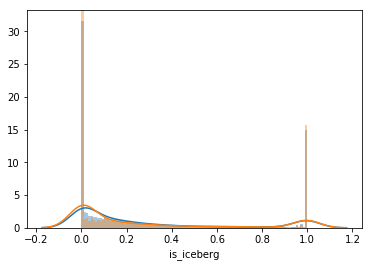

In [15]:
%matplotlib inline
import seaborn as sns
sns.distplot(alt_sub.is_iceberg, bins = 100)
sns.distplot(hack_sub.is_iceberg, bins = 100)


In [330]:
# Not processed (i.e. median is the same as prediction)
# 50 / 50: high = 1326, low = 2445
# 525 / 475: high = 1295, low = 2397
# 475 / 525: high = 1352, low = 2397
# 55 / 45: high = 1277, low = 2355



In [331]:
alt_sub[(alt_sub.is_iceberg != alt_sub.is_iceberg_median) & (alt_sub.is_iceberg < 0.9) & (alt_sub.is_iceberg > 0.1)]
# Todo:
## Set thresholds for the following:
## - if > 0.99, set to 0.9999
## - elif > 0.975, set to 0.99
## - elif > 0.95, set to 0.975
## - elif > 0.9, set to 0.95
## - else set to 0.9
## 
## - if < 0.01, set to 0.0001
## - elif < 0.025, set to 0.001
## - elif < 0.05, set to 0.025
## - elif < 0.1, set to 0.05
## - else set to 0.1


,id,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4,is_iceberg_5,is_iceberg_max,is_iceberg_min,is_iceberg_mean,is_iceberg_median,is_iceberg,is_iceberg_base,is_iceberg_base2
173,50984a87,0.584841,0.554083,0.595546,0.864788,0.737092,0.805742,0.864788,0.554083,0.690349,0.666319,0.864788,0.805742,0.864788
778,8e6e087e,0.464508,0.171106,0.439035,0.461402,0.152394,0.395355,0.464508,0.152394,0.347300,0.417195,0.152394,0.395355,0.461402
1277,c0298b7d,0.575598,0.534898,0.710859,0.884321,0.578833,0.857798,0.884321,0.534898,0.690385,0.644846,0.884321,0.857798,0.884321
1286,ee110bda,0.388660,0.173463,0.473537,0.116333,0.104039,0.200821,0.473537,0.104039,0.242809,0.187142,0.104039,0.200821,0.116333
1497,d2041d74,0.751510,0.524952,0.636224,0.723147,0.875691,0.747435,0.875691,0.524952,0.709826,0.735291,0.875691,0.747435,0.723147
1613,5b6305ad,0.135295,0.152183,0.194532,0.237819,0.445098,0.264948,0.445098,0.135295,0.238312,0.216175,0.135295,0.264948,0.237819
1765,4936bb64,0.523528,0.583737,0.686114,0.793417,0.850491,0.697615,0.850491,0.523528,0.689150,0.691865,0.850491,0.697615,0.793417
2299,7cd4c795,0.238632,0.221611,0.140563,0.181014,0.444805,0.393306,0.444805,0.140563,0.269988,0.230121,0.140563,0.393306,0.181014
2331,de1b8020,0.811385,0.651071,0.588819,0.747066,0.888044,0.672261,0.888044,0.588819,0.726441,0.709664,0.888044,0.672261,0.747066
2773,f2de5d65,0.107757,0.135113,0.241193,0.435854,0.485201,0.271857,0.485201,0.107757,0.279496,0.256525,0.107757,0.271857,0.435854


In [332]:
# 3772 not using min or max values
# 653 where median is between 0.4 and 0.6 (virtually guessing)
# 422 where median is as above, and best model is more confident

# concat_sub.where(concat_sub["is_iceberg_median"] == concat_sub["is_iceberg"]).dropna()
mix_best = (alt_sub["is_iceberg_base"] + alt_sub["is_iceberg_base2"]) / 2
# alt_sub[((alt_sub["is_iceberg_median"] > 0.4) & (alt_sub["is_iceberg_median"] < 0.6)) & ((alt_sub["is_iceberg_base"] > 0.6) | (alt_sub["is_iceberg_base"] < 0.4))]
# alt_sub[((alt_sub["is_iceberg_median"] > 0.4) & (alt_sub["is_iceberg_median"] < 0.6)) & ((alt_sub["is_iceberg_base2"] > 0.6) | (alt_sub["is_iceberg_base2"] < 0.4))]
# alt_sub[(alt_sub["is_iceberg_median"] == alt_sub["is_iceberg"]) & ((alt_sub["is_iceberg_median"] > 0.4) & (alt_sub["is_iceberg_median"] < 0.6)) & ((mix_best > 0.6) | (mix_best < 0.4)) & (((alt_sub["is_iceberg_median"] > 0.5) & (alt_sub["is_iceberg_base"] > 0.5) & (alt_sub["is_iceberg_base2"] > 0.5)) | ((alt_sub["is_iceberg_median"] < 0.5) & (alt_sub["is_iceberg_base"] < 0.5) & (alt_sub["is_iceberg_base2"] < 0.5)))]
# alt_sub[(alt_sub["is_iceberg_median"] == alt_sub["is_iceberg"]) & ((alt_sub["is_iceberg_median"] > 0.4) & (alt_sub["is_iceberg_median"] < 0.6)) & (((alt_sub["is_iceberg_median"] > 0.5) & (alt_sub["is_iceberg_base"] > 0.5) & (alt_sub["is_iceberg_base2"] > 0.5)) | ((alt_sub["is_iceberg_median"] < 0.5) & (alt_sub["is_iceberg_base"] < 0.5) & (alt_sub["is_iceberg_base2"] < 0.5)))]
alt_sub[(alt_sub["is_iceberg_median"] == alt_sub["is_iceberg"]) & ((alt_sub["is_iceberg_median"] > 0.4) & (alt_sub["is_iceberg_median"] < 0.6)) & (((alt_sub["is_iceberg_median"] > 0.5) & (alt_sub["is_iceberg_base"] > 0.6) & (alt_sub["is_iceberg_base2"] > 0.6)) | ((alt_sub["is_iceberg_median"] < 0.5) & (alt_sub["is_iceberg_base"] < 0.4) & (alt_sub["is_iceberg_base2"] < 0.4)))]


,id,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4,is_iceberg_5,is_iceberg_max,is_iceberg_min,is_iceberg_mean,is_iceberg_median,is_iceberg,is_iceberg_base,is_iceberg_base2
113,f7fb320d,8.656891e-01,0.400228,0.090834,0.806971,0.019349,0.676068,0.865689,1.934936e-02,0.476523,0.538148,0.538148,0.676068,0.806971
266,e1f9c0e4,9.999996e-01,0.330282,0.075353,0.735023,0.042659,0.714512,1.000000,4.265867e-02,0.482972,0.522397,0.522397,0.714512,0.735023
365,bfc7a3f2,9.058345e-01,0.499088,0.087597,0.775588,0.008781,0.631174,0.905834,8.780810e-03,0.484677,0.565131,0.565131,0.631174,0.775588
476,8333ebed,1.000000e+00,0.188794,0.326091,0.847523,0.053881,0.733694,1.000000,5.388114e-02,0.524997,0.529892,0.529892,0.733694,0.847523
593,86a3b5cc,1.230178e-01,0.344443,0.035718,0.773440,0.886482,0.676259,0.886482,3.571792e-02,0.473227,0.510351,0.510351,0.676259,0.773440
728,5d1291bb,9.993553e-01,0.323545,0.034314,0.723134,0.008980,0.742665,0.999355,8.979855e-03,0.471999,0.523339,0.523339,0.742665,0.723134
745,7405c131,7.667413e-01,0.396925,0.113099,0.920368,0.032224,0.810954,0.920368,3.222430e-02,0.506719,0.581833,0.581833,0.810954,0.920368
909,75463cb0,5.467561e-01,0.151805,0.483501,0.900316,0.013888,0.656016,0.900316,1.388787e-02,0.458714,0.515129,0.515129,0.656016,0.900316
979,970a9821,3.141030e-01,0.118818,0.560533,0.947278,0.503259,0.859037,0.947278,1.188183e-01,0.550505,0.531896,0.531896,0.859037,0.947278
1000,99a7b417,6.279386e-05,0.310524,0.559626,0.969012,0.465957,0.811346,0.969012,6.279386e-05,0.519421,0.512791,0.512791,0.811346,0.969012


In [64]:
concat_sub[concat_sub["is_iceberg"] != alt_sub["is_iceberg"]]
# print(concat_sub["is_iceberg"][21])
# print(alt_sub["is_iceberg"][21])
# print(concat_sub["is_iceberg"][128])
# print(alt_sub["is_iceberg"][128])


,id,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4,is_iceberg_5,is_iceberg_max,is_iceberg_min,is_iceberg_mean,is_iceberg_median,is_iceberg,is_iceberg_base,is_iceberg_base2
0,5941774d,0.021383,0.010011,0.003657,0.016455,0.220130,0.023473,0.220130,0.003657,0.049185,0.018919,0.003657,0.023473,0.016455
3,e7f018bb,0.973822,0.997395,0.999148,0.999509,0.992729,0.998656,0.999509,0.973822,0.993543,0.998026,0.999509,0.998656,0.999509
6,29e7727e,0.159443,0.001177,0.061324,0.104459,0.034815,0.038130,0.159443,0.001177,0.066558,0.049727,0.001177,0.038130,0.104459
15,f156976f,0.002377,0.000385,0.026703,0.165304,0.111248,0.015157,0.165304,0.000385,0.053529,0.020930,0.000385,0.015157,0.165304
16,68a117cc,0.003824,0.020630,0.008328,0.359770,0.005428,0.079457,0.359770,0.003824,0.079573,0.014479,0.003824,0.079457,0.359770
19,5f6d3988,0.873364,0.995045,0.988368,0.997509,0.920994,0.920312,0.997509,0.873364,0.949265,0.954681,0.997509,0.920312,0.997509
22,a39a1427,0.021985,0.161371,0.048990,0.467032,0.010779,0.481515,0.481515,0.010779,0.198612,0.105181,0.010779,0.481515,0.467032
23,82fbe8ed,0.013517,0.039872,0.005822,0.015852,0.496669,0.027595,0.496669,0.005822,0.099888,0.021723,0.005822,0.027595,0.015852
26,bbad5958,0.009260,0.077825,0.028322,0.218823,0.304988,0.041525,0.304988,0.009260,0.113457,0.059675,0.009260,0.041525,0.218823
27,54527583,0.116400,0.039691,0.005434,0.114403,0.006679,0.149363,0.149363,0.005434,0.071995,0.077047,0.005434,0.149363,0.114403


In [65]:
blah2 = np.where(np.all(concat_sub.iloc[:,1:model_amount] > cutoff_lo, axis=1), 
                                    concat_sub['is_iceberg_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:model_amount] < cutoff_hi, axis=1),
                                             concat_sub['is_iceberg_min'], 
                                             concat_sub['is_iceberg_median']))


In [66]:
blah2 = np.all(concat_sub.iloc[:,1:model_amount] > 0.8, axis=1)
print(blah2[blah2 == True].shape)
blah2 = np.all(concat_sub.iloc[:,1:model_amount] > 0.7, axis=1)
print(blah2[blah2 == True].shape)
blah2 = np.all(concat_sub.iloc[:,1:model_amount] > 0.6, axis=1)
print(blah2[blah2 == True].shape)
blah_iceberg = np.all(concat_sub.iloc[:,1:model_amount] > 0.5, axis=1)
print(blah_iceberg[blah_iceberg == True].shape)

blah2 = np.all(concat_sub.iloc[:,1:model_amount] < 0.2, axis=1)
print(blah2[blah2 == True].shape)
blah2 = np.all(concat_sub.iloc[:,1:model_amount] < 0.3, axis=1)
print(blah2[blah2 == True].shape)
blah2 = np.all(concat_sub.iloc[:,1:model_amount] < 0.4, axis=1)
print(blah2[blah2 == True].shape)
blah_ship = np.all(concat_sub.iloc[:,1:model_amount] < 0.5, axis=1)
print(blah_ship[blah_ship == True].shape)

len_all = len(concat_sub)
len_iceberg_processed = len(blah_iceberg[blah_iceberg == True])
len_ship_processed = len(blah_ship[blah_ship == True])
len_unprocessed = len_all - len_iceberg_processed - len_ship_processed
print(len_all)
print(len_iceberg_processed)
print(len_ship_processed)
print(len_unprocessed)


# Things to try:
# - Straight (0.6, 0.4) and (0.5, 0.5) consensus thresholds
# - Calculate the difference between the median value and the min / max value
# - If thresholds / consensus is "good enough", use diff b/w median and min / max
# - Maybe see if there's consensus between the top 2 / 3 models... if so, use diff b/w median and min / max

# - clipping (0.001, 0.999)
# - different thresholds (0.55, 0.45)

(937,)
(1098,)
(1220,)
(1326,)
(1828,)
(2068,)
(2278,)
(2445,)
8424
1326
2445
4653


In [67]:
# Find values that are on the fence...

def test(val):
    if val < 0.5:
        return -1
    elif val > 0.5:
        return -1
    
    return val 

blah = concat_sub.apply(lambda x: test(x["is_iceberg"]), axis=1)
blah = blah[blah >= 0]

In [68]:
print(blah.shape)
blah

(0,)


Series([], dtype: int64)

In [69]:
concat_sub

,id,is_iceberg_0,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4,is_iceberg_5,is_iceberg_max,is_iceberg_min,is_iceberg_mean,is_iceberg_median,is_iceberg,is_iceberg_base,is_iceberg_base2
0,5941774d,2.138313e-02,1.001100e-02,0.003657,1.645529e-02,0.220130,2.347304e-02,0.220130,3.657331e-03,0.049185,0.018919,0.003657,2.347304e-02,1.645529e-02
1,4023181e,6.183937e-01,4.049912e-01,0.020802,9.866307e-01,0.014379,3.756849e-01,0.986631,1.437879e-02,0.403480,0.390338,0.390338,3.756849e-01,9.866307e-01
2,b20200e4,9.098931e-07,7.188838e-03,0.001704,1.559171e-03,0.000041,6.848715e-03,0.007189,9.098931e-07,0.002890,0.001632,0.000100,6.848715e-03,1.559171e-03
3,e7f018bb,9.738217e-01,9.973954e-01,0.999148,9.995090e-01,0.992729,9.986560e-01,0.999509,9.738217e-01,0.993543,0.998026,0.999509,9.986560e-01,9.995090e-01
4,4371c8c3,4.257437e-01,6.751659e-02,0.001759,9.976440e-01,0.074289,3.550633e-02,0.997644,1.758835e-03,0.267076,0.070903,0.070903,3.550633e-02,9.976440e-01
5,a8d9b1fd,4.091924e-05,1.395310e-01,0.036811,8.380730e-01,0.082405,5.532939e-01,0.838073,4.091924e-05,0.275026,0.110968,0.110968,5.532939e-01,8.380730e-01
6,29e7727e,1.594431e-01,1.177437e-03,0.061324,1.044588e-01,0.034815,3.812961e-02,0.159443,1.177437e-03,0.066558,0.049727,0.001177,3.812961e-02,1.044588e-01
7,92a51ffb,9.893829e-01,9.997948e-01,0.999978,9.997451e-01,0.994780,9.985010e-01,0.999978,9.893829e-01,0.997030,0.999123,0.999900,9.985010e-01,9.997451e-01
8,c769ac97,4.145949e-13,2.410319e-04,0.001725,9.538788e-07,0.087789,4.076076e-04,0.087789,4.145949e-13,0.015027,0.000324,0.000100,4.076076e-04,9.538788e-07
9,aee0547d,1.269119e-16,1.919658e-04,0.004978,1.497171e-05,0.074415,2.713778e-04,0.074415,1.269119e-16,0.013312,0.000232,0.000100,2.713778e-04,1.497171e-05


In [70]:
# Understanding log loss

from sklearn.metrics import log_loss

print("Log loss: Volume of data")
print("========================")
print("Tiny data, extremely confident and accurate:", log_loss([1, 0], [1, 0]))
print("Slightly more data, confident and accurate:", log_loss([1, 0], [0.999, 0.001]))
print("Even more data, confident and accurate:", log_loss([1, 0, 1, 0, 0, 1, 0], [0.999, 0.001, 0.999, 0.001, 0.001, 0.999, 0.001]))
print("All accurate except one 50/50:", log_loss([1, 0, 1, 0, 0, 1, 0], [0.999, 0.001, 0.999, 0.001, 0.5, 0.999, 0.001]))

print("\nLog loss: Some examples")
print("=========================")
print("14 records, perfect:", log_loss([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]))
print("14 records, very slight clipping:", log_loss([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], [0.9999, 0.0001, 0.9999, 0.0001, 0.0001, 0.9999, 0.0001, 0.9999, 0.0001, 0.9999, 0.0001, 0.0001, 0.9999, 0.0001]))
print("14 records, slight clipping:", log_loss([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], [0.999, 0.001, 0.999, 0.001, 0.001, 0.999, 0.001, 0.999, 0.001, 0.999, 0.001, 0.001, 0.999, 0.001]))
print("14 records, 2 50/50 guesses:", log_loss([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], [0.999, 0.001, 0.999, 0.001, 0.5, 0.999, 0.001, 0.999, 0.001, 0.999, 0.001, 0.5, 0.999, 0.001]))
print("14 records, all 50/50 guesses:", log_loss([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))
print("14 records, 1 very wrong:", log_loss([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], [0.999, 0.001, 0.999, 0.001, 0.999, 0.999, 0.001, 0.999, 0.001, 0.999, 0.001, 0.001, 0.999, 0.001]))
print("14 records, 1 perfectly wrong:", log_loss([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], [0.999, 0.001, 0.999, 0.001, 1, 0.999, 0.001, 0.999, 0.001, 0.999, 0.001, 0.001, 0.999, 0.001]))

print("\nLog loss: Effect of right answers")
print("===================================")
print("14 records, perfect:", log_loss([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]))
print("14 records, very slight clipping:", log_loss([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], [0.9999, 0.0001, 0.9999, 0.0001, 0.0001, 0.9999, 0.0001, 0.9999, 0.0001, 0.9999, 0.0001, 0.0001, 0.9999, 0.0001]))
print("14 records, 95 percent sure:", log_loss([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], [0.95, 0.05, 0.95, 0.05, 0.05, 0.95, 0.05, 0.95, 0.05, 0.95, 0.05, 0.05, 0.95, 0.05]))
print("14 records, 90 percent sure:", log_loss([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], [0.9, 0.1, 0.9, 0.1, 0.1, 0.9, 0.1, 0.9, 0.1, 0.9, 0.1, 0.1, 0.9, 0.1]))
print("14 records, 80 percent sure:", log_loss([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], [0.8, 0.2, 0.8, 0.2, 0.2, 0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 0.2, 0.8, 0.2]))
print("14 records, 50 percent sure:", log_loss([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))
print("14 records, 1 weak accurate:", log_loss([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0], [0.999, 0.001, 0.999, 0.001, 0.3, 0.999, 0.001, 0.999, 0.001, 0.999, 0.001, 0.001, 0.999, 0.001]))

print("\nLog loss: Effect of wrong answers")
print("===================================")
print("14 records, perfect:", log_loss([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1], [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]))
print("14 records, very slight clipping:", log_loss([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1], [0.9999, 0.0001, 0.9999, 0.0001, 0.0001, 0.9999, 0.0001, 0.9999, 0.0001, 0.9999, 0.0001, 0.0001, 0.9999, 0.0001]))
print("14 records, 95 percent sure:", log_loss([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1], [0.95, 0.05, 0.95, 0.05, 0.05, 0.95, 0.05, 0.95, 0.05, 0.95, 0.05, 0.05, 0.95, 0.05]))
print("14 records, 90 percent sure:", log_loss([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1], [0.9, 0.1, 0.9, 0.1, 0.1, 0.9, 0.1, 0.9, 0.1, 0.9, 0.1, 0.1, 0.9, 0.1]))
print("14 records, 80 percent sure:", log_loss([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1], [0.8, 0.2, 0.8, 0.2, 0.2, 0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 0.2, 0.8, 0.2]))
print("14 records, 50 percent sure:", log_loss([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))
print("14 records, 1 weak accurate:", log_loss([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1], [0.999, 0.001, 0.999, 0.001, 0.3, 0.999, 0.001, 0.999, 0.001, 0.999, 0.001, 0.001, 0.999, 0.001]))

print("\nLog loss: How many wrongs make a right")
print("========================================")

perf_data = [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]
perf_pred = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]
print("Perfect, " + str(len(perf_data)) + " records, but 1 wrong:", log_loss(perf_data, perf_pred))

vs_data = [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]
vs_pred = [0.9999, 0.0001, 0.9999, 0.9999, 0.0001, 0.9999, 0.0001, 0.9999, 0.0001, 0.9999, 0.0001, 0.0001, 0.9999, 0.0001, 0.9999, 0.0001, 0.9999, 0.0001, 0.0001, 0.9999, 0.0001]
print("Very slight clipping, " + str(len(vs_data)) + " records, 1 wrong:", log_loss(vs_data, vs_pred))

s_data = [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]
s_pred = [0.999, 0.001, 0.999, 0.001, 0.999, 0.999, 0.001, 0.999, 0.001, 0.999, 0.001, 0.001, 0.999, 0.001, 0.001]
print("Slight clipping, " + str(len(s_data)) + " records, 1 wrong:", log_loss(s_data, s_pred))

vs_pred_2 = np.clip(perf_pred, 0.0001, 0.9999)
print("Very slight clipping, " + str(len(vs_pred_2)) + " records, 1 wrong:", log_loss(perf_data, vs_pred_2))

s_pred_2 = np.clip(perf_pred, 0.001, 0.999)
print("Slight clipping, " + str(len(s_pred_2)) + " records, 1 wrong:", log_loss(perf_data, s_pred_2))


Log loss: Volume of data
Tiny data, extremely confident and accurate: 9.99200722163e-16
Slightly more data, confident and accurate: 0.00100050033358
Even more data, confident and accurate: 0.00100050033358
All accurate except one 50/50: 0.0998785975088

Log loss: Some examples
14 records, perfect: 9.99200722163e-16
14 records, very slight clipping: 0.000100005000333
14 records, slight clipping: 0.00100050033358
14 records, 2 50/50 guesses: 0.0998785975088
14 records, all 50/50 guesses: 0.69314718056
14 records, 1 very wrong: 0.49434012738
14 records, 1 perfectly wrong: 2.46804160691

Log loss: Effect of right answers
14 records, perfect: 9.99200722163e-16
14 records, very slight clipping: 0.000100005000333
14 records, 95 percent sure: 0.0512932943876
14 records, 90 percent sure: 0.105360515658
14 records, 80 percent sure: 0.223143551314
14 records, 50 percent sure: 0.69314718056
14 records, 1 weak accurate: 0.026405817734

Log loss: Effect of wrong answers
14 records, perfect: 34.53911

In [71]:
one_true = np.ones(400)
one_false = np.zeros(400)
one_concat = np.append(one_true, one_false)
one_predict = np.full(800, 0.5)
log_loss(one_concat, one_predict, labels = [0, 1])

0.69314718055994518

In [72]:
one_predict[0:70] = 0.6
one_predict[70:100] = 0.4
log_loss(one_concat, one_predict, labels = [0, 1])

0.68556192751475709

In [73]:
one_predict[0:70] = 0.7
one_predict[70:100] = 0.3
log_loss(one_concat, one_predict, labels = [0, 1])

0.68286182074681379

In [74]:
one_predict[0:50] = 0.90
one_predict[70:100] = 0.5
log_loss(one_concat, one_predict, labels = [0, 1])

0.6479987080880325

In [75]:
one_predict[0:50] = 0.99
one_predict[70:100] = 0.5
log_loss(one_concat, one_predict, labels = [0, 1])

0.64204182185026215

In [76]:
one_predict[0:400] = 0.8795
one_predict[400:800] = 0.1205
log_loss(one_concat, one_predict, labels = [0, 1])

0.12840171480452425

In [77]:
one_predict[0:400] = 0.93
one_predict[400:800] = 0.07
# one_predict[1] = 0.1
log_loss(one_concat, one_predict, labels = [0, 1])

0.072570692834835457

In [78]:
one_predict[0:40] = 0.95
one_predict[400:440] = 0.05
# one_predict[1] = 0.05
log_loss(one_concat, one_predict, labels = [0, 1])

0.070442952990106972

In [79]:
one_true = np.ones(400)
one_false = np.zeros(400)
one_concat = np.append(one_true, one_false)
one_predict = np.full(800, 0.5)
log_loss(one_concat, one_predict, labels = [0, 1])

0.69314718055994518

In [80]:
one_predict[0:11] = 0.6
one_predict[400:411] = 0.4
log_loss(one_concat, one_predict, labels = [0, 1])

0.68813333774811158

In [81]:
one_predict[11:18] = 0.4
one_predict[411:418] = 0.6
log_loss(one_concat, one_predict, labels = [0, 1])

0.69203834989611013

In [82]:
11/18

0.6111111111111112